## **2C.** Plotting a logistic regression model for the probability of diverted US Flights  

## To access the project files to run this notebook

Check github (link: https://github.com/inc0gn1k0/submission_final_st2195.git) to access the entire project folder.


## **3.** Plotting a logistic regression model for the probability of diverted US Flights 

```
Analysis Recipe:

1. **Database Connection**
   - Libraries: DBI, RSQLite
   - Connect to local SQLite database.

2. **Data Querying and Aggregation**
   - Iterate over years, executing SQL queries.
   - Aggregate diverted flights and carrier data.

3. **Feature Preparation**
   - Calculate percentages for diverted counts.
   - Rank airports and carriers by diverted counts.

4. **Data Merging and Cleaning**
   - Join features to core dataset using `dplyr::left_join`.
   - Clean and preprocess data for modeling.

5. **Model Training**
   - Libraries: caret, pROC for modeling and evaluation.
   - Train logistic regression models, evaluate with ROC-AUC.

6. **Visualization**
   - Libraries: ggplot2 for plotting.
   - Generate ROC curves, coefficient bar plots.

7. **Hyperparameter Tuning**
   - Library: glmnet for Lasso regression.
   - Optimize model with cross-validation.

8. **Analysis and Insights**
   - Analyze coefficients, ROC curves.
   - Draw insights from model performance across years.

9. **Cleanup**
   - Close database connections.
   - Clear variables to free up memory.

```

In [2]:
#Part1

#Custom Feature: Airport Ranking by Frequency of Diverted Flights
#Airport Rankings (Rank DepDelayCount, Rank DepDelayLength + Rank ArrDelayCount, Rank ArrDelayLength)
#Airport Ranking of DepDelayCount

import sqlite3 
import pandas as pd
import os 

subset_of_years = [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007] #adjust this according to your available compute resources :)......less years means lower probability of a kernel crash on your local machine.

#connect to DB
current_dir = os.getcwd()
pathname = os.path.join(current_dir, '..', 'raw_data', 'comp97to07.db') #the full path logic looks like --> go to current_dir then go to its parent then enter /raw_data/comp97to07.db
conn = sqlite3.connect(pathname)

temp_storage_ranked_1 = []

for i, years in enumerate(subset_of_years, start=1998):

    diverted_planes = f'''
    SELECT Dest AS Airport, COUNT(Diverted) AS DivertedCount
    FROM Y{i}
    WHERE Diverted = 1 AND Cancelled != 1 
    GROUP BY Dest
    ORDER BY DivertedCount Desc
    '''
    df_ranked_divertedcount = pd.read_sql_query(diverted_planes, conn)
    temp_storage_ranked_1.append(df_ranked_divertedcount)

df_ranked_divertedcount_2004_2007 = pd.concat(temp_storage_ranked_1).groupby(['Airport'], as_index=False).sum().sort_values(['DivertedCount'], ascending=False, ignore_index=True)

#df_ranked_divertedcount_2004_2007['Rank'] = range(1, len(df_ranked_divertedcount_2004_2007)+1) #stopped using rank as this does not improve our model, used raw score instead
#df_ranked_divertedcount_2004_2007 = df_ranked_divertedcount_2004_2007[['Rank', 'Airport', 'DivertedCount']]
sum_diverted_count = df_ranked_divertedcount_2004_2007['DivertedCount'].sum()
df_ranked_divertedcount_2004_2007['DivertedCount'] = df_ranked_divertedcount_2004_2007['DivertedCount']/sum_diverted_count
percent_check = df_ranked_divertedcount_2004_2007['DivertedCount'].sum()

df_ranked_divertedcount_2004_2007 = df_ranked_divertedcount_2004_2007.rename(columns={'DivertedCount': 'DivertedCount%'})

print(df_ranked_divertedcount_2004_2007.head(10))
print(df_ranked_divertedcount_2004_2007.tail(10))

print(sum_diverted_count)
print(percent_check)


temp_storage_ranked_2 = []

for i, years in enumerate(subset_of_years, start=1998):

    carrier_diverted = f'''
    SELECT 
        UniqueCarrier AS UniqueCarrier, 
        SUM(CASE WHEN Diverted = 1 THEN 1 ELSE 0 END) AS DivertedCount
    FROM Y{i}
    WHERE Cancelled != 1
    GROUP BY UniqueCarrier
    ORDER BY DivertedCount DESC
    '''
    df_ranked_carrier_diverted = pd.read_sql_query(carrier_diverted, conn)
    temp_storage_ranked_2.append(df_ranked_carrier_diverted)

conn.close()

df_ranked_carrier_diverted_2004_2007 = pd.concat(temp_storage_ranked_2).groupby(['UniqueCarrier'], as_index=False).sum().sort_values(['DivertedCount'], ascending=False, ignore_index=True)

#df_ranked_divertedcount_2004_2007['Rank'] = range(1, len(df_ranked_divertedcount_2004_2007)+1) #stopped using rank as this does not improve our model, used raw score instead
#df_ranked_divertedcount_2004_2007 = df_ranked_divertedcount_2004_2007[['Rank', 'Airport', 'DivertedCount']]
sum_carrier_diverted_count = df_ranked_carrier_diverted_2004_2007['DivertedCount'].sum()
df_ranked_carrier_diverted_2004_2007['DivertedCount'] = df_ranked_carrier_diverted_2004_2007['DivertedCount']/sum_carrier_diverted_count
percent_check = df_ranked_carrier_diverted_2004_2007['DivertedCount'].sum()

df_ranked_carrier_diverted_2004_2007 = df_ranked_carrier_diverted_2004_2007.rename(columns={'DivertedCount': 'Carrier%Diverted'})

print(df_ranked_carrier_diverted_2004_2007.head(23))
print(df_ranked_carrier_diverted_2004_2007.tail(23))

print(sum_carrier_diverted_count)
print(percent_check)

  Airport  DivertedCount%
0     DFW        0.076814
1     ORD        0.056902
2     IAH        0.054639
3     ATL        0.045358
4     LGA        0.040121
5     EWR        0.034379
6     PHL        0.029312
7     MSP        0.027079
8     DCA        0.022012
9     STL        0.021997
    Airport  DivertedCount%
302     RCA        0.000007
303     BJI        0.000007
304     ADK        0.000007
305     EAU        0.000007
306     INL        0.000007
307     BLI        0.000007
308     CMX        0.000007
309     ITO        0.000007
310     PIR        0.000007
311     LBF        0.000007
134793
1.0
   UniqueCarrier  Carrier%Diverted
0             AA          0.141558
1             WN          0.123085
2             DL          0.104464
3             US          0.093024
4             UA          0.092720
5             NW          0.087148
6             CO          0.064180
7             XE          0.050099
8             MQ          0.047206
9             AS          0.038251
10        

In [3]:
#Part 2
#Custom Feature 2: PRODUCING AIRPORT DELAY RANKING STEP 1
#Airport Rankings (Rank DepDelayCount, Rank DepDelayLength + Rank ArrDelayCount, Rank ArrDelayLength)

#Airport Ranking of DepDelayCount
import sqlite3 
import pandas as pd
import os 

list_of_years = [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007] #adjust this according to your available compute resources :)......less years means lower probability of a kernel crash on your local machine.

# Connect to the database
current_dir = os.getcwd()
pathname = os.path.join(current_dir, '..', 'raw_data', 'comp97to07.db') #the full path logic looks like --> go to current_dir then go to its parent then enter /raw_data/comp97to07.db
conn = sqlite3.connect(pathname)

temp_storage_ranked_1 = []

for i, years in enumerate(list_of_years, start=1998):

    dep_delayed_planes = f'''
    SELECT Origin AS Airport, COUNT(DepDelay) AS DepDelayCount
    FROM Y{i}
    WHERE DepDelay >= 15 and Cancelled != 1
    GROUP BY Origin
    ORDER BY DepDelayCount Desc
    '''
    df_ranked_depdelay = pd.read_sql_query(dep_delayed_planes, conn)
    temp_storage_ranked_1.append(df_ranked_depdelay)

conn.close()

df_ranked_depcount_2004_2007 = pd.concat(temp_storage_ranked_1).groupby(['Airport'], as_index=False).sum().sort_values(['DepDelayCount'], ascending=False, ignore_index=True)
df_ranked_depcount_2004_2007['DepDelayCount'] = df_ranked_depcount_2004_2007['DepDelayCount'].astype(int)
sum_depcount = df_ranked_depcount_2004_2007['DepDelayCount'].sum()

df_ranked_depcount_2004_2007['DepDelayCount'] = df_ranked_depcount_2004_2007['DepDelayCount']/sum_depcount
df_ranked_depcount_2004_2007 = df_ranked_depcount_2004_2007.rename(columns={'DepDelayCount': 'DepDelayCount%'})
percent_check = df_ranked_depcount_2004_2007['DepDelayCount%'].sum()
#df_ranked_depcount_2005_2007['Rank'] = range(1, len(df_ranked_depcount_2005_2007)+1) #we used raw scores instead of the rankings in our model
#df_ranked_depcount_2005_2007 = df_ranked_depcount_2005_2007[['Rank', 'Airport', 'DepDelayCount']]


print(df_ranked_depcount_2004_2007.head(10))
print(df_ranked_depcount_2004_2007.tail(10))
print(percent_check)

#Airport Ranking of ArrDelayCount

temp_storage_ranked_3 = []

current_dir = os.getcwd()
pathname = os.path.join(current_dir, '..', 'raw_data', 'comp97to07.db') #the full path logic looks like --> go to current_dir then go to its parent then enter /raw_data/comp97to07.db
conn = sqlite3.connect(pathname)

for i, years in enumerate(list_of_years, start=1998):

    arr_delayed_planes = f'''
    SELECT Origin AS Airport, COUNT(ArrDelay) AS ArrDelayCount
    FROM Y{i}
    WHERE ArrDelay >= 15 and Cancelled != 1
    GROUP BY Origin
    ORDER BY ArrDelayCount Desc
    '''
    df_ranked_arrdelay = pd.read_sql_query(arr_delayed_planes, conn)
    temp_storage_ranked_3.append(df_ranked_arrdelay)

conn.close()

df_ranked_arrcount_2004_2007 = pd.concat(temp_storage_ranked_3).groupby(['Airport'], as_index=False).sum().sort_values(['ArrDelayCount'], ascending=False, ignore_index=True)
df_ranked_arrcount_2004_2007['ArrDelayCount'] = df_ranked_arrcount_2004_2007['ArrDelayCount'].astype(int)
#df_ranked_arrcount_2005_2007['Rank'] = range(1, len(df_ranked_arrcount_2005_2007)+1) #we used raw scores instead of the rankings in our model
#df_ranked_arrcount_2005_2007 = df_ranked_arrcount_2005_2007[['Rank', 'Airport', 'ArrDelayCount']]
sum_arrcount = df_ranked_arrcount_2004_2007['ArrDelayCount'].sum()

df_ranked_arrcount_2004_2007['ArrDelayCount'] = df_ranked_arrcount_2004_2007['ArrDelayCount']/sum_arrcount
df_ranked_arrcount_2004_2007 = df_ranked_arrcount_2004_2007.rename(columns={'ArrDelayCount': 'ArrDelayCount%'})
percent_check = df_ranked_arrcount_2004_2007['ArrDelayCount%'].sum()


print(df_ranked_arrcount_2004_2007.head(10))
print(df_ranked_arrcount_2004_2007.tail(10))
print(percent_check)

'''

#Airport Ranking of ArrDelayLength

temp_storage_ranked_4 = []

current_dir = os.getcwd()
pathname = os.path.join(current_dir, '..', 'raw_data', 'comp97to07.db') #the full path logic looks like --> go to current_dir then go to its parent then enter /raw_data/comp97to07.db
conn = sqlite3.connect(pathname)

for i, years in enumerate(list_of_years, start=2004):

    arr_delayed_planes = f'''
    #SELECT Origin AS Airport, SUM(ArrDelay) AS ArrDelayLength
    #FROM Y{i}
    #WHERE ArrDelay >= 15 and Cancelled != 1
    #GROUP BY Origin
    #ORDER BY ArrDelayLength Desc
'''
    df_ranked_arrdelay = pd.read_sql_query(arr_delayed_planes, conn)
    temp_storage_ranked_4.append(df_ranked_arrdelay)

conn.close()

df_ranked_arrlength_2004_2007 = pd.concat(temp_storage_ranked_4).groupby(['Airport'], as_index=False).sum().sort_values(['ArrDelayLength'], ascending=False, ignore_index=True)
df_ranked_arrlength_2004_2007['ArrDelayLength'] = df_ranked_arrlength_2004_2007['ArrDelayLength'].astype(int)
df_ranked_arrlength_2004_2007['Rank'] = range(1, len(df_ranked_arrlength_2004_2007)+1) #we used raw scores instead of the rankings in our model
df_ranked_arrlength_2004_2007 = df_ranked_arrlength_2004_2007[['Rank', 'Airport', 'ArrDelayLength']]

print(df_ranked_arrlength_2004_2007.head(10))
print(df_ranked_arrlength_2004_2007.tail(10))

#Airport Ranking of DepDelayLength

temp_storage_ranked_2 = []

current_dir = os.getcwd()
pathname = os.path.join(current_dir, '..', 'raw_data', 'comp97to07.db') #the full path logic looks like --> go to current_dir then go to its parent then enter /raw_data/comp97to07.db
conn = sqlite3.connect(pathname)

for i, years in enumerate(list_of_years, start=2004):

    dep_delayed_planes = f'''
    #SELECT Origin AS Airport, SUM(DepDelay) AS DepDelayLength
    #FROM Y{i}
    #WHERE DepDelay >= 15 and Cancelled != 1
    #GROUP BY Origin
    #ORDER BY DepDelayLength Desc
'''
    df_ranked_depdelay = pd.read_sql_query(dep_delayed_planes, conn)
    temp_storage_ranked_2.append(df_ranked_depdelay)

conn.close()

df_ranked_deplength_2004_2007 = pd.concat(temp_storage_ranked_2).groupby(['Airport'], as_index=False).sum().sort_values(['DepDelayLength'], ascending=False, ignore_index=True)
df_ranked_deplength_2004_2007['DepDelayLength'] = df_ranked_deplength_2004_2007['DepDelayLength'].astype(int)
df_ranked_deplength_2004_2007['Rank'] = range(1, len(df_ranked_deplength_2004_2007)+1) #we used raw scores instead of the rankings in our model
df_ranked_deplength_2004_2007 = df_ranked_deplength_2004_2007[['Rank', 'Airport', 'DepDelayLength']]

print(df_ranked_deplength_2004_2007.head(10))
print(df_ranked_deplength_2004_2007.tail(10))

'''

  Airport  DepDelayCount%
0     ORD        0.070011
1     ATL        0.064554
2     DFW        0.048369
3     PHX        0.034462
4     LAX        0.032808
5     LAS        0.029371
6     DEN        0.026108
7     DTW        0.025300
8     EWR        0.024226
9     PHL        0.023402
    Airport  DepDelayCount%
314     OGD    4.583369e-07
315     LNY    4.583369e-07
316     MKK    3.666695e-07
317     CKB    3.666695e-07
318     PIR    3.666695e-07
319     FMN    2.750021e-07
320     PUB    1.833347e-07
321     CYS    1.833347e-07
322     RDR    1.833347e-07
323     BFF    9.166737e-08
1.0
  Airport  ArrDelayCount%
0     ORD        0.068780
1     ATL        0.063822
2     DFW        0.047095
3     PHX        0.031447
4     LAX        0.031441
5     DTW        0.028762
6     EWR        0.027433
7     DEN        0.026999
8     LAS        0.026120
9     MSP        0.025584
    Airport  ArrDelayCount%
315     LNY    3.097026e-07
316     RDR    2.322769e-07
317     FMN    2.322769e-07
318 

"\n    df_ranked_depdelay = pd.read_sql_query(dep_delayed_planes, conn)\n    temp_storage_ranked_2.append(df_ranked_depdelay)\n\nconn.close()\n\ndf_ranked_deplength_2004_2007 = pd.concat(temp_storage_ranked_2).groupby(['Airport'], as_index=False).sum().sort_values(['DepDelayLength'], ascending=False, ignore_index=True)\ndf_ranked_deplength_2004_2007['DepDelayLength'] = df_ranked_deplength_2004_2007['DepDelayLength'].astype(int)\ndf_ranked_deplength_2004_2007['Rank'] = range(1, len(df_ranked_deplength_2004_2007)+1) #we used raw scores instead of the rankings in our model\ndf_ranked_deplength_2004_2007 = df_ranked_deplength_2004_2007[['Rank', 'Airport', 'DepDelayLength']]\n\nprint(df_ranked_deplength_2004_2007.head(10))\nprint(df_ranked_deplength_2004_2007.tail(10))\n\n"

In [6]:
#Part 3

#Producing DF of our Complete Feature Set
#why do we leave out origin and destination? ANS: because the latitude and longitudes as well as the Diverted rankings of the airports, can identify the airports.
#I also made sure only to include airports and flights that have had at least one diverted incident.
'''
Here I
Read a Query for each year to extract the relevant default features.
Performed the following merges to join our custom features to our default features:
Merge for Destination DivertedCount Complete...
Merge for Destination DepDelayCount Complete...
Merge for Destination ArrDelayCount Complete...
Merge for Carrier%Diverted Complete...1

I standardized CRSDepTime and CRSArrTime from within the query using:
        (y.CRSArrTime)/10000 AS CRSArrTime, 
        (y.CRSDepTime)/10000 AS CRSDepTime, 

I had initially included these features but dropped them because they added unecessary computational complexity:
   
        ao.lat AS OriginLatitude,
        ao.long AS OriginLongitude, 
        ad.lat AS DestinationLatitude,
        ad.long AS DestinationLongitude, 

I kept y.DayofMonth because it was important for indexing our resulting rows...but was not used thereafter

These conditions were important for our query:
    WHERE y.Cancelled != 1 
            AND y.tailnum IN (
            SELECT tailnum 
            FROM Y{year} AS sub_y
            WHERE sub_y.Diverted = 1
        )
            AND y.Origin IN (
            SELECT Origin
            FROM Y{year} AS sub_y
            WHERE sub_y.Diverted = 1
            )
            AND y.Dest IN (
            SELECT Dest
            FROM Y{year} AS sub_y
            WHERE sub_y.Diverted = 1
            )

'''
import pandas as pd
import sqlite3
import gc  # Garbage Collector interface is a default module in python
import os

# Connect to the database
current_dir = os.getcwd()
pathname = os.path.join(current_dir, '..', 'raw_data', 'comp97to07.db') #the full path logic looks like --> go to current_dir then go to its parent then enter /raw_data/comp97to07.db
conn = sqlite3.connect(pathname)

subset_of_years = [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007] #adjust this according to your available compute resources :)......less years means lower probability of a kernel crash on your local machine.

def diverted_merge_with_suffix(df_main, df_rank, on_column):
    new_column_name = f'DivertedCount%_{on_column}'
    df_merged = df_main.merge(df_rank[['Airport', 'DivertedCount%']], how='left', left_on=on_column, right_on='Airport')
    df_merged.rename(columns={'DivertedCount%': new_column_name}, inplace=True) 
    df_merged.drop(columns=['Airport'], inplace=True)
    return df_merged

def dep_delaycount_merge_with_suffix(df_main, df_rank, on_column):
    new_column_name = f'DepDelayCount%_{on_column}'
    df_merged = df_main.merge(df_rank[['Airport', 'DepDelayCount%']], how='left', left_on=on_column, right_on='Airport')
    df_merged.rename(columns={'DepDelayCount%': new_column_name}, inplace=True) 
    df_merged.drop(columns=['Airport'], inplace=True)
    return df_merged

def arr_delaycount_merge_with_suffix(df_main, df_rank, on_column):
    new_column_name = f'ArrDelayCount%_{on_column}'
    df_merged = df_main.merge(df_rank[['Airport', 'ArrDelayCount%']], how='left', left_on=on_column, right_on='Airport')
    df_merged.rename(columns={'ArrDelayCount%': new_column_name}, inplace=True) 
    df_merged.drop(columns=['Airport'], inplace=True)
    return df_merged

def carrier_delaycount_merge_with_suffix(df_main, df_rank, on_column):
    new_column_name = f'Carrier%Diverted_{on_column}'
    df_merged = df_main.merge(df_rank[['UniqueCarrier', 'Carrier%Diverted']], how='left', left_on=on_column, right_on='UniqueCarrier')
    df_merged.rename(columns={'Carrier%Diverted': new_column_name}, inplace=True) 
    df_merged.drop(columns=['UniqueCarrier'], inplace=True)
    #df_merged[new_column_name].fillna(0, inplace=True)
    return df_merged    

'''
def dep_delaylength_merge_with_suffix(df_main, df_rank, on_column, delay_type):
    suffix = f'_{on_column}'
    new_column_name = f'Rank_{delay_type}{suffix}'
    df_merged = df_main.merge(df_rank[['Airport', 'Rank']], how='left', left_on=on_column, right_on='Airport', suffixes=('', suffix))
    df_merged.rename(columns={'Rank': new_column_name}, inplace=True) 
    df_merged.drop(columns=['Airport'], inplace=True)
    print(f'Columns after merging op: {df_main.columns}')
    return df_merged

def arr_delaylength_merge_with_suffix(df_main, df_rank, on_column, delay_type):
    suffix = f'_{on_column}'
    new_column_name = f'Rank_{delay_type}{suffix}'
    df_merged = df_main.merge(df_rank[['Airport', 'Rank']], how='left', left_on=on_column, right_on='Airport', suffixes=('', suffix))
    print(f'Columns after merging op: {df_main.columns}')
    df_merged.rename(columns={'Rank': new_column_name}, inplace=True) 
    df_merged.drop(columns=['Airport'], inplace=True)
    print(f'Columns after merging op: {df_main.columns}')
    return df_merged
'''

temp_storage_ranked_5 = []

count = 0
for year in subset_of_years: #modify ArrDelay and DepDelay Binary to just focus on Diverted

    count += 1 
    query = f"""
    SELECT 
        y.Year, 
        y.Month,
        y.DayofMonth, 
        y.DayOfWeek, 
        CAST(y.CRSArrTime AS REAL)/10000 AS CRSArrTime, 
        CAST(y.CRSDepTime AS REAL)/10000 AS CRSDepTime, 
        y.UniqueCarrier, 
        y.Distance, 
        y.Origin,
        y.Dest,       
        y.Diverted AS Diverted
    FROM Y{year} AS y
    LEFT JOIN planes AS p ON y.tailnum = p.tailnum
    LEFT JOIN airports AS ao ON y.Origin = ao.iata 
    LEFT JOIN airports AS ad ON y.Dest = ad.iata
    WHERE y.Cancelled != 1 
            AND y.tailnum IN (
            SELECT tailnum 
            FROM Y{year} AS sub_y
            WHERE sub_y.Diverted = 1
        )
            AND y.Origin IN (
            SELECT Origin
            FROM Y{year} AS sub_y
            WHERE sub_y.Diverted = 1
            )
            AND y.Dest IN (
            SELECT Dest
            FROM Y{year} AS sub_y
            WHERE sub_y.Diverted = 1
            )
    ORDER BY y.Year, y.Month, y.DayofMonth, y.DayOfWeek, y.CRSDepTime
    """
    df_core_features = pd.read_sql_query(query, conn)
    print(f'Query Read {count}')

    #df_core_features = diverted_merge_with_suffix(df_core_features, df_ranked_divertedcount_2004_2007, 'Origin')
    #print(f'Merge for Origin DivertedCount Complete...{count}')
    df_core_features = diverted_merge_with_suffix(df_core_features, df_ranked_divertedcount_2004_2007, 'Dest')
    print(f'Merge for Destination DivertedCount Complete...{count}')  
    #df_core_features.drop(columns=['Origin', 'Dest'], inplace=True)

    #df_core_features = dep_delaycount_merge_with_suffix(df_core_features, df_ranked_depcount_2004_2007, 'Origin')
    #print(f'Merge for Origin DepDelayCount Complete...{count}')
    df_core_features = dep_delaycount_merge_with_suffix(df_core_features, df_ranked_depcount_2004_2007, 'Dest')
    print(f'Merge for Destination DepDelayCount Complete...{count}')  
    #df_core_features.drop(columns=['Origin', 'Dest'], inplace=True)    

    #df_core_features = arr_delaycount_merge_with_suffix(df_core_features, df_ranked_arrcount_2004_2007, 'Origin')
    #print(f'Merge for Origin ArrDelayCount Complete...{count}')
    df_core_features = arr_delaycount_merge_with_suffix(df_core_features, df_ranked_arrcount_2004_2007, 'Dest')
    print(f'Merge for Destination ArrDelayCount Complete...{count}')  
    #df_core_features.drop(columns=['Origin', 'Dest'], inplace=True)
    
    df_core_features = carrier_delaycount_merge_with_suffix(df_core_features, df_ranked_carrier_diverted_2004_2007, 'UniqueCarrier')
    print(f'Merge for Carrier%Diverted Complete...{count}') 


    '''
    #no longer needed, as I dropped these features. they add uneccessary complexity
    df_core_features = dep_delaylength_merge_with_suffix(df_core_features, df_ranked_deplength_2004_2007, 'Origin', 'DepDelayLength')
    print(f'Merge for Origin DepDelayLength Complete...{count}')
    df_core_features = dep_delaylength_merge_with_suffix(df_core_features, df_ranked_deplength_2004_2007, 'Dest', 'DepDelayLength')
    print(f'Merge for Destination DepDelayLength Complete...{count}')  
    #df_core_features.drop(columns=['Origin', 'Dest'], inplace=True)  

    df_core_features = arr_delaylength_merge_with_suffix(df_core_features, df_ranked_arrlength_2004_2007, 'Origin', 'ArrDelayLength')
    print(f'Merge for Origin ArrDelayLength Complete...{count}')
    df_core_features = arr_delaylength_merge_with_suffix(df_core_features, df_ranked_arrlength_2004_2007, 'Dest', 'ArrDelayLength')
    print(f'Merge for Destination ArrDelayLength Complete...{count}')  
    df_core_features.drop(columns=['Origin', 'Dest'], inplace=True)         
    '''

    temp_storage_ranked_5.append(df_core_features)
    del df_core_features
    gc.collect()

print(f'Concatenating...')  
df_complete_airplane_features = pd.concat(temp_storage_ranked_5, ignore_index=True)
print(f'Concatenation complete...')  
del temp_storage_ranked_5
gc.collect()

conn.close()

print(df_complete_airplane_features.head(10))
print(df_complete_airplane_features.tail(30))
print(f'Number of rows:{len(df_complete_airplane_features)}')

print(f'Exporting...')  
df_complete_airplane_features.to_csv('./complete-airplane-feature-set.csv')#, index=False) #file is saved in the working directory of this script.....relative file path :)

Query Read 1
Merge for Destination DivertedCount Complete...1
Merge for Destination DepDelayCount Complete...1
Merge for Destination ArrDelayCount Complete...1
Merge for Carrier%Diverted Complete...1
Query Read 2
Merge for Destination DivertedCount Complete...2
Merge for Destination DepDelayCount Complete...2
Merge for Destination ArrDelayCount Complete...2
Merge for Carrier%Diverted Complete...2
Query Read 3
Merge for Destination DivertedCount Complete...3
Merge for Destination DepDelayCount Complete...3
Merge for Destination ArrDelayCount Complete...3
Merge for Carrier%Diverted Complete...3
Query Read 4
Merge for Destination DivertedCount Complete...4
Merge for Destination DepDelayCount Complete...4
Merge for Destination ArrDelayCount Complete...4
Merge for Carrier%Diverted Complete...4
Query Read 5
Merge for Destination DivertedCount Complete...5
Merge for Destination DepDelayCount Complete...5
Merge for Destination ArrDelayCount Complete...5
Merge for Carrier%Diverted Complete...5


In [7]:
#Part 4

import pandas as pd
import gc 
#Further Data Cleaning and Shaping
df = pd.read_csv('./complete-airplane-feature-set.csv')
df_complete_airplane_features_cleaned = df.dropna()
#list_of_numeric_cols = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSArrTime', 'CRSDepTime','Distance', 'Diverted','DivertedCount%_Dest', 'DepDelayCount%_Dest', 'ArrDelayCount%_Dest', 'Carrier%Diverted_UniqueCarrier']

#df_complete_airplane_features_cleaned[list_of_numeric_cols] = df_complete_airplane_features_cleaned[list_of_numeric_cols].astype(int)
print(df_complete_airplane_features_cleaned.head())
print(f'Number of rows after dropping NaN: {len(df_complete_airplane_features_cleaned)}') #after our final cleaning to mop up columns with missing values....we went from 21319321 records to 1649264

df_complete_airplane_features_cleaned.rename(columns={df_complete_airplane_features_cleaned.columns[0] : 'IndexVariable'}, inplace=True) #renamed first column to IndexVariable
print(df_complete_airplane_features_cleaned.columns)  # Check columns after dropping NA

del df
gc.collect()

# Placing target variable at end of Dataframe
cols = [col for col in df_complete_airplane_features_cleaned.columns if col not in ['Diverted']] + ['Diverted'] # Ensure the target column is the last one
df_complete_airplane_features_final = df_complete_airplane_features_cleaned[cols]

#Save to disk to prevent kernel crashes
print(len(df_complete_airplane_features_final))
print(df_complete_airplane_features_final.head())
df_complete_airplane_features_final.to_csv('./complete-airplane-feature-set-FINAL.csv', index=False) #file is saved in the working directory of this script.....relative file path :)

   Unnamed: 0  Year  Month  DayofMonth  DayOfWeek  CRSArrTime  CRSDepTime  \
0           0  1998      1           1          4         0.0         0.0   
1           1  1998      1           1          4         0.0         0.0   
2           2  1998      1           1          4         0.0         0.0   
3           3  1998      1           1          4         0.0         0.0   
4           4  1998      1           1          4         0.0         0.0   

   Distance Origin Dest  Diverted  DivertedCount%_Dest  DepDelayCount%_Dest  \
0       868    DFW  PHX         0              0.01828             0.034462   
1       868    DFW  PHX         0              0.01828             0.034462   
2       868    DFW  PHX         0              0.01828             0.034462   
3       868    DFW  PHX         0              0.01828             0.034462   
4       868    DFW  PHX         0              0.01828             0.034462   

   ArrDelayCount%_Dest  Carrier%Diverted_UniqueCarrier  
0    

/var/folders/8g/4w0hd20x7091lw53vz0nw2dm0000gn/T/ipykernel_52628/1502733874.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_complete_airplane_features_cleaned.rename(columns={df_complete_airplane_features_cleaned.columns[0] : 'IndexVariable'}, inplace=True) #renamed first column to IndexVariable


55767925
   IndexVariable  Year  Month  DayofMonth  DayOfWeek  CRSArrTime  CRSDepTime  \
0              0  1998      1           1          4         0.0         0.0   
1              1  1998      1           1          4         0.0         0.0   
2              2  1998      1           1          4         0.0         0.0   
3              3  1998      1           1          4         0.0         0.0   
4              4  1998      1           1          4         0.0         0.0   

   Distance Origin Dest  DivertedCount%_Dest  DepDelayCount%_Dest  \
0       868    DFW  PHX              0.01828             0.034462   
1       868    DFW  PHX              0.01828             0.034462   
2       868    DFW  PHX              0.01828             0.034462   
3       868    DFW  PHX              0.01828             0.034462   
4       868    DFW  PHX              0.01828             0.034462   

   ArrDelayCount%_Dest  Carrier%Diverted_UniqueCarrier  Diverted  
0             0.031447      

In [8]:
#Part 5

#Show diverted as a % of total flights is a small fraction
#Here we demonstrate that the target variable is a minority class.

print(f'This is the number of diverted flights between 1998 and 2007: {sum_diverted_count}')

sum_sample_space = len(df_complete_airplane_features_final)

print(f'This is the total size of our training/test split data: {sum_sample_space}')

percentage_of_sample_space = (sum_diverted_count/sum_sample_space)*100

print(f'This is the % of our sample that observed the phenomenon: {percentage_of_sample_space.round(4)}%')

#This means we need to undersample our majority class, to rectify the class imbalance...



This is the number of diverted flights between 1998 and 2007: 134793
This is the total size of our training/test split data: 55767925
This is the % of our sample that observed the phenomenon: 0.2417%


In [6]:
'''
This code is deprecated...

#Better Features:
#Add ArrDelay Ranking of Airports, DepDelay Ranking of Airports.......Run the model again, maybe with more iterations.
#show that diverted flights as a fraction of our total observations is a tiny percentage
#either undersample majority class or penalize the minority class more, to adjust for class imbalance

#Original ML code that worked
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.sparse import hstack, csr_matrix
from scipy.stats import zscore
import gc  # Garbage collector for manual memory management
import numpy as np

df = pd.read_csv('/Users/nikolaijaniszewsky/Desktop/My_Stuff/UOL_Course_Content/Academia/2024/ST2195/ST2195_coursework/raw_data/complete-airplane-feature-set-FINAL.csv')
print(f'Dataframe length before downsampling: {len(df)}')

#addressing distance variable scale issues using MinMaxScaler....
features_to_normalize = ['Distance']
#df[features_to_normalize] = df[features_to_normalize].apply(zscore)
scaler = MinMaxScaler(feature_range=(0, 1))
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])


print(df.head(5))
print(df.tail(5))



df_sampled = df#.sample(frac=1.0, random_state=42) #to test performance of our parameters, we can use sampling method

numeric_columns = ['Month','CRSArrTime', 'CRSDepTime','Distance', 'DivertedCount%_Dest', 'DepDelayCount%_Dest', 'ArrDelayCount%_Dest', 'Carrier%Diverted_UniqueCarrier'] 

#making my dataset more memory efficient
for col in numeric_columns:
        df_sampled[col] = pd.to_numeric(df_sampled[col], errors='coerce', downcast='float') #to save on memory for the local compute


# Subset of years we're interested in
subset_of_years = [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007]

# Initialize a OneHotEncoder
encoder = OneHotEncoder(sparse=True, handle_unknown='ignore')

# Placeholder for coefficients
coefs_dict = {}

counter = 0

for year in subset_of_years:
    counter += 1
    # Filter dataframe for the current year
    df_year = df_sampled[df_sampled['Year'] == year]
    
    all_columns = numeric_columns + ['DayOfWeek']
    # Prepare features and target....
    X = df_year[all_columns]
    y = df_year['Diverted']

    print(f'Feature Set and Target Set {counter}...')
    
    # One-hot encode 'UniqueCarrier'
    categorical_features = ['DayOfWeek']
    X_encoded = pd.get_dummies(X, columns=categorical_features)

    print(f'Data Successfully Labelled {counter}...')
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

    print(f'Data Split Successfully {counter}...')

    print(f'Training Model {counter}...')
    # Initialize and fit the logistic regression model
    model = LogisticRegression(max_iter=1500, tol=0.05,solver='saga', class_weight='balanced', penalty='l2', C=1) #!
    model.fit(X_train, y_train)
    
    # Store the coefficients for visualization
    coefs_dict[year] = model.coef_[0]



#original features minus the one hot encoded feature.......try removing 'OriginLatitude', 'OriginLongitude'
original_features = ['Month','CRSArrTime', 'CRSDepTime','Distance', 'DivertedCount%_Dest', 'DepDelayCount%_Dest', 'ArrDelayCount%_Dest', 'Carrier%Diverted_UniqueCarrier']

# Calculate positions for each year's group of bars
year_positions = np.arange(len(subset_of_years))

# Width of bars and the gap between groups
width = 0.07
gap = 0.15

# Use the 'tab20' colormap for distinct colors
colormap = plt.cm.get_cmap('tab20', 16)  # Get 13 distinct colors from 'tab20'
colors = [colormap(i) for i in range(16)]

plt.figure(figsize=(20, 10))

# Adjust the logic to find indices for 'UniqueCarrier' one-hot encoded features
unique_carrier_columns = [col for col in X_encoded.columns if col.startswith('DayOfWeek')]

# Integrate the fix for handling coefficient summarization and indexing
for i, feature in enumerate(original_features + ['DayOfWeek']):  # Including 'UniqueCarrier' as a placeholder for its summarized value
    summarized_coefs = []

    for year in subset_of_years:
        if feature == 'DayOfWeek':
            # Correctly handle the unique carrier coefficients
            carrier_indices = [X_encoded.columns.get_loc(col) for col in unique_carrier_columns]
            carrier_coefs = np.mean([coefs_dict[year][idx] for idx in carrier_indices if idx < len(coefs_dict[year])])
            summarized_coefs.append(carrier_coefs)
        else:
            # Handle coefficients for other features
            if feature in X_encoded.columns:
                coef_idx = X_encoded.columns.get_loc(feature)
                summarized_coefs.append(coefs_dict[year][coef_idx])
            else:
                summarized_coefs.append(0)  # Placeholder for missing features

    # Adjust feature_positions calculation to accommodate the actual number of features + 'UniqueCarrier'
    feature_positions = year_positions + (i - (len(original_features) + 1) / 2) * width + gap
    plt.bar(feature_positions, summarized_coefs, width, label=feature, color=colors[i % len(colors)])

plt.xticks(year_positions, labels=subset_of_years)
plt.ylabel('Coefficient Value')
plt.title('Logistic Regression Coefficients Across Years')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/Users/nikolaijaniszewsky/Desktop/My_Stuff/UOL_Course_Content/Academia/2024/ST2195/ST2195_coursework/st2195_processedfiles/images_for_report/2C-Logistic-Regression-YoY')
plt.show()




# Perform 5-fold cross-validation and compute the AUC score for each fold
auc_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
# Compute the average AUC score across all folds
average_auc = np.mean(auc_scores)
print(f"Average AUC Score across 5 folds: {average_auc}")



for year in subset_of_years:
    # Prepare the data for the current year.........try removing 'OriginLatitude', 'OriginLongitude'
    df_year = df_sampled[df_sampled['Year'] == year]
    X = df_year[all_columns]
    y = df_year['Diverted']

    X_encoded = pd.get_dummies(X, columns=['DayOfWeek'])
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)
    
    # Train the model
    model = LogisticRegression(max_iter=1500, tol=0.05,solver='saga', class_weight='balanced', penalty='l2', C=1) #!
    model.fit(X_train, y_train)
    
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'ROC curve for Year {year} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Yearly Comparison')
plt.legend(loc="lower right")
plt.savefig('/Users/nikolaijaniszewsky/Desktop/My_Stuff/UOL_Course_Content/Academia/2024/ST2195/ST2195_coursework/st2195_processedfiles/images_for_report/2C_ROC_2004_2007')
plt.show()

'''

'\nThis code is deprecated...\n\n#Better Features:\n#Add ArrDelay Ranking of Airports, DepDelay Ranking of Airports.......Run the model again, maybe with more iterations.\n#show that diverted flights as a fraction of our total observations is a tiny percentage\n#either undersample majority class or penalize the minority class more, to adjust for class imbalance\n\n#Original ML code that worked\nimport pandas as pd\nfrom sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score\nfrom sklearn.preprocessing import OneHotEncoder\nfrom sklearn.preprocessing import MinMaxScaler\nimport matplotlib.pyplot as plt\nfrom scipy.sparse import hstack, csr_matrix\nfrom scipy.stats import zscore\nimport gc  # Garbage collector for manual memory management\nimport numpy as np\n\ndf = pd.read_csv(\'/Users/nikolaijaniszewsky/Desktop/My_Stuff/UOL_Cours

Dataframe length before downsampling: 55767925
Dataframe length AFTER downsampling: 1482569

          IndexVariable  Year  Month  DayofMonth  DayOfWeek  CRSArrTime  \
31202545       31202545  2004      3          20          6      0.0820   
33601925       33601926  2004      8           4          3      0.2118   
47493371       47493381  2006     10           3          2      0.1343   
18810143       18810143  2001      8          26          7      0.1451   
44360562       44360568  2006      4          12          3      0.1244   

          CRSDepTime  Distance Origin Dest  DivertedCount%_Dest  \
31202545      0.0820  0.027469    ATL  MGM             0.000193   
33601925      0.2003  0.076954    DEN  COD             0.000067   
47493371      0.1200  0.192688    FLL  IAH             0.054639   
18810143      0.1335  0.056352    PHL  MHT             0.002693   
44360562      0.1008  0.099374    MSP  IND             0.003101   

          DepDelayCount%_Dest  ArrDelayCount%_Dest  \

/var/folders/8g/4w0hd20x7091lw53vz0nw2dm0000gn/T/ipykernel_55165/3960962174.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', 16)  # Get 13 distinct colors from 'tab20'


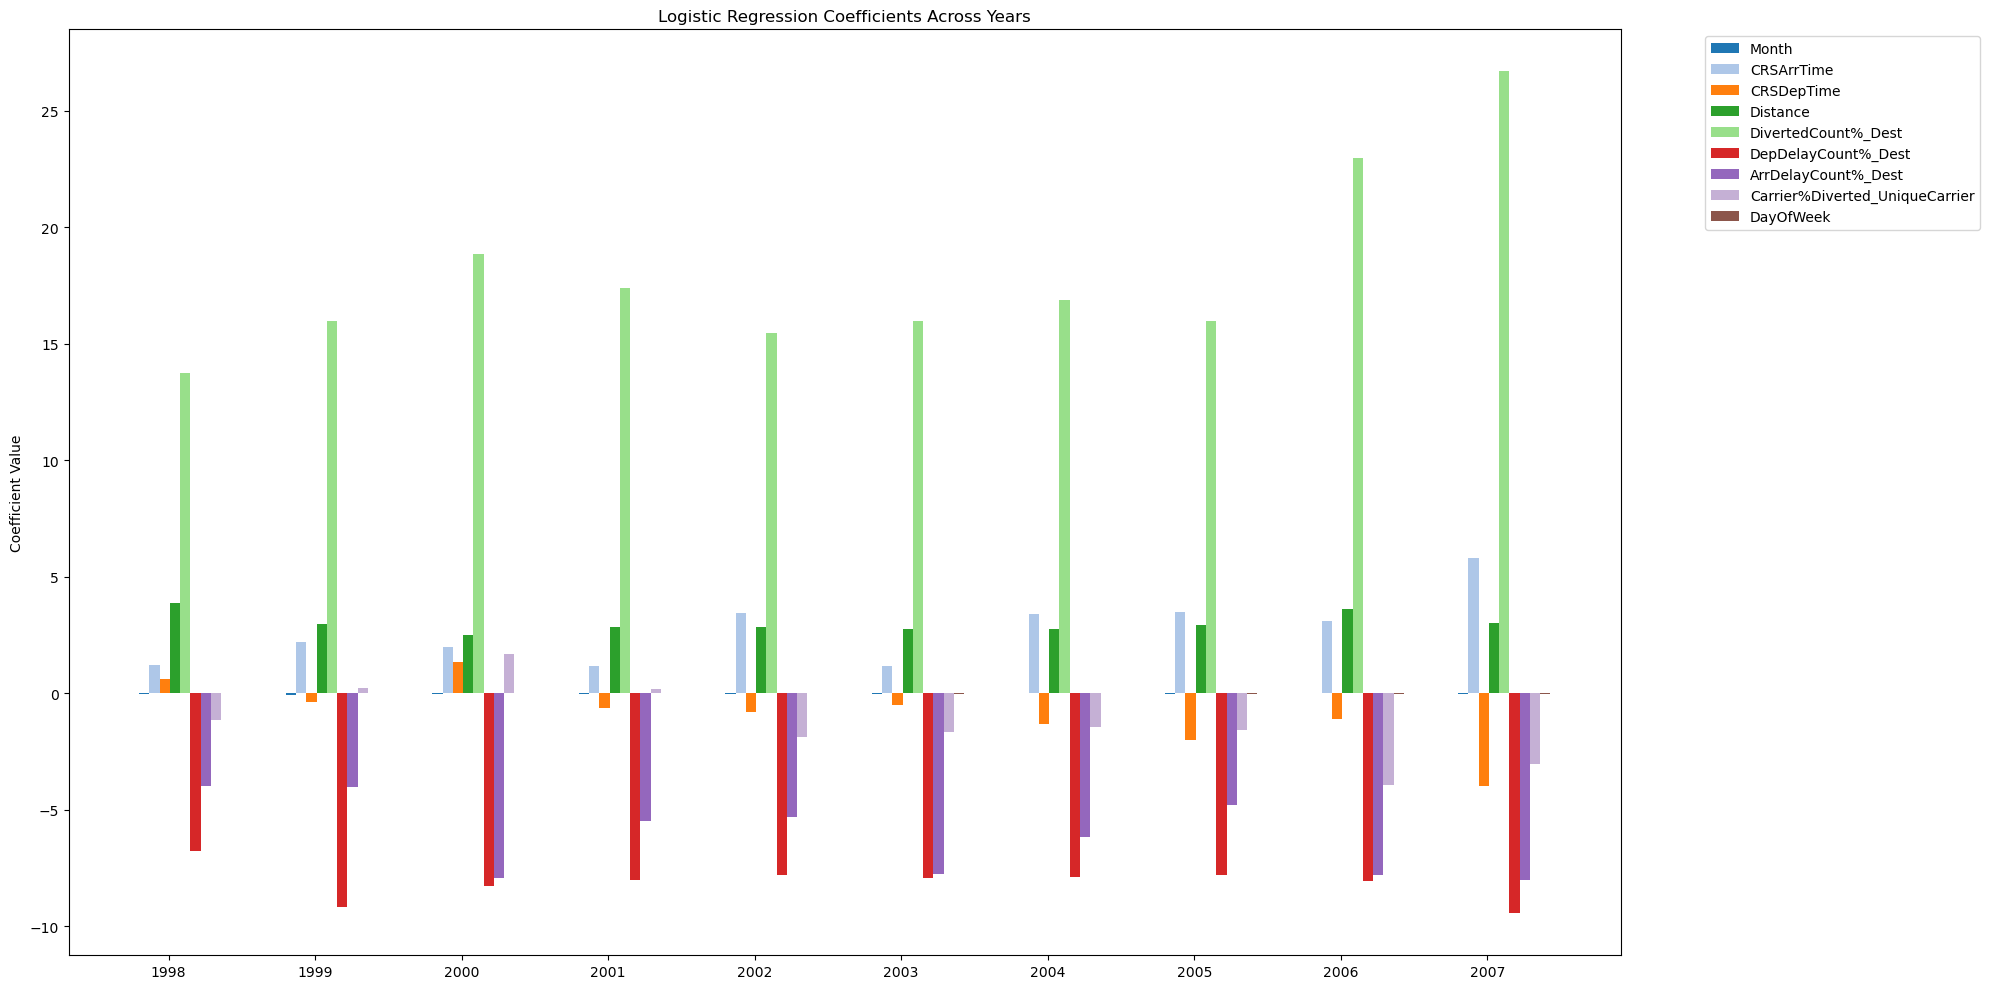

Average AUC Score across 10 folds: 0.6643304434857964


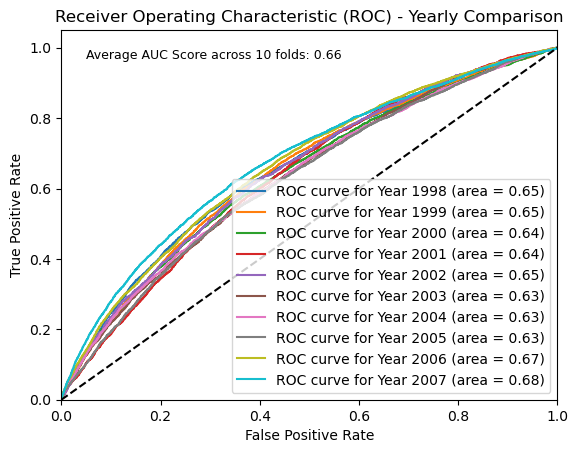

In [1]:
#Part 6

#NOW WE TRY WITH DOWNSAMPLING AND MORE DATA...
#Since we only included carriers that had a diversion (see query in code block 1), and airports that had a diversion (see query in code block 1)...we can safely downsample without losing valuable data...

#Original ML code that worked
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import gc  # Garbage collector for manual memory management
import numpy as np
import os 

df = pd.read_csv('./complete-airplane-feature-set-FINAL.csv')
print(f'Dataframe length before downsampling: {len(df)}')


df_majority = df[df.Diverted==0]
df_minority = df[df.Diverted==1]

# Downsample majority class
from sklearn.utils import resample
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=10*len(df_minority),     # to match minority class
                                   random_state=42) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Final downsampled sample (without shuffling)
df_sampled = df_downsampled

#standardize Distance variable
features_to_normalize = ['Distance']
#df[features_to_normalize] = df[features_to_normalize].apply(zscore)
scaler = MinMaxScaler(feature_range=(0, 1))
df_sampled[features_to_normalize] = scaler.fit_transform(df_sampled[features_to_normalize])

print(f'Dataframe length AFTER downsampling: {len(df_sampled)}\n')
print(df_sampled.head(5))
print(df_sampled.tail(5))

numeric_columns = ['Month','CRSArrTime', 'CRSDepTime','Distance', 'DivertedCount%_Dest', 'DepDelayCount%_Dest', 'ArrDelayCount%_Dest', 'Carrier%Diverted_UniqueCarrier'] 

#making my dataset more memory efficient
for col in numeric_columns:
        df_sampled[col] = pd.to_numeric(df_sampled[col], errors='coerce', downcast='float') #to save on memory for the local compute

# Subset of years we're interested in
subset_of_years = [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007] #adjust this according to your available compute resources :)......less years means lower probability of a kernel crash on your local machine.
# Initialize a OneHotEncoder
encoder = OneHotEncoder()#sparse=True, handle_unknown='ignore')

# Placeholder for coefficients
coefs_dict = {}

counter = 0

for year in subset_of_years:
    counter += 1
    # Filter dataframe for the current year
    df_year = df_sampled[df_sampled['Year'] == year]
    
    all_columns = numeric_columns + ['DayOfWeek']
    # Prepare features and target....
    X = df_year[all_columns]
    y = df_year['Diverted']

    print(f'Feature Set and Target Set {counter}...')
    
    # One-hot encode 'UniqueCarrier'
    categorical_features = ['DayOfWeek']
    X_encoded = pd.get_dummies(X, columns=categorical_features)

    print(f'Data Successfully Labelled {counter}...')
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

    print(f'Data Split Successfully {counter}...')

    print(f'Training Model {counter}...')
    # Initialize and fit the logistic regression model
    model = LogisticRegression(max_iter=10000, tol=0.0001,solver='saga', class_weight='balanced', penalty='l2', C=1) #!
    model.fit(X_train, y_train)
    
    # Store the coefficients for visualization
    coefs_dict[year] = model.coef_[0]


#original features minus the one hot encoded feature.......try removing 'OriginLatitude', 'OriginLongitude'
original_features = ['Month','CRSArrTime', 'CRSDepTime','Distance', 'DivertedCount%_Dest', 'DepDelayCount%_Dest', 'ArrDelayCount%_Dest', 'Carrier%Diverted_UniqueCarrier']

# Calculate positions for each year's group of bars
year_positions = np.arange(len(subset_of_years))

# Width of bars and the gap between groups
width = 0.07
gap = 0.15

# Use the 'tab20' colormap for distinct colors
colormap = plt.cm.get_cmap('tab20', 16)  # Get 13 distinct colors from 'tab20'
colors = [colormap(i) for i in range(16)]

tab20_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
                "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
                "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
                "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5"]

plt.figure(figsize=(20, 10))

# Adjust the logic to find indices for 'UniqueCarrier' one-hot encoded features
unique_carrier_columns = [col for col in X_encoded.columns if col.startswith('DayOfWeek')]

# Handling coefficient summarization and indexing
for i, feature in enumerate(original_features + ['DayOfWeek']):  # Including 'UniqueCarrier' as a placeholder for its summarized value
    summarized_coefs = []

    for year in subset_of_years:
        if feature == 'DayOfWeek':
            # Correctly handle the unique carrier coefficients
            carrier_indices = [X_encoded.columns.get_loc(col) for col in unique_carrier_columns]
            carrier_coefs = np.mean([coefs_dict[year][idx] for idx in carrier_indices if idx < len(coefs_dict[year])])
            summarized_coefs.append(carrier_coefs)
        else:
            # Handle coefficients for other features
            if feature in X_encoded.columns:
                coef_idx = X_encoded.columns.get_loc(feature)
                summarized_coefs.append(coefs_dict[year][coef_idx])
            else:
                summarized_coefs.append(0)  # Placeholder for missing features

    # Adjust feature_positions calculation to accommodate the actual number of features + 'UniqueCarrier'
    feature_positions = year_positions + (i - (len(original_features) + 1) / 2) * width + gap
    plt.bar(feature_positions, summarized_coefs, width, label=feature, color=colors[i % len(colors)])

plt.xticks(year_positions, labels=subset_of_years)
plt.ylabel('Coefficient Value')
plt.title('Logistic Regression Coefficients Across Years')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

if not os.path.exists('./py_images'): #making sure that we create a directory to guarantee code runs anywhere...
    os.makedirs('./py_images')

plt.savefig('./py_images/2C_LogisticRegression_python.png')
plt.show()


# Perform 5-fold cross-validation and compute the AUC score for each fold
auc_scores = cross_val_score(model, X, y, cv=100, scoring='roc_auc')
# Compute the average AUC score across all folds
average_auc = np.mean(auc_scores)
print(f"Average AUC Score across 10 folds: {average_auc}")


for year in subset_of_years:
    # Prepare the data for the current year.........try removing 'OriginLatitude', 'OriginLongitude'
    df_year = df_sampled[df_sampled['Year'] == year]
    X = df_year[all_columns]
    y = df_year['Diverted']

    X_encoded = pd.get_dummies(X, columns=['DayOfWeek'])
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)
    
    # Train the model
    model = LogisticRegression(max_iter=10000, tol=0.0001,solver='saga', class_weight='balanced', penalty='l2', C=1) #!
    model.fit(X_train, y_train)
    
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba) #I used underscore as a placeholder variable, to indicate I do not intend to use the threshold value returned by roc_curve()
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'ROC curve for Year {year} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Yearly Comparison')
plt.legend(loc="lower right")
plt.text(x=0.05, y=0.95, s=f"Average AUC Score across 10 folds: {average_auc:.2f}", 
         fontsize=9, transform=plt.gca().transAxes, verticalalignment='top')

if not os.path.exists('./py_images'): #making sure that we create a directory to guarantee code runs anywhere...
    os.makedirs('./py_images')

plt.savefig('./py_images/2C_ROC_python.png')
plt.show()

In [5]:
#Part 7
import dataframe_image as dfi
import dataframe_image as dfi
feature_names = numeric_columns + ['DayOfWeek']

# Initialize a dictionary to hold the sum of coefficients for each feature
sum_coefs = {feature: 0.0 for feature in feature_names}
# Initialize a counter for the number of years
num_years = len(coefs_dict)

# Sum up the coefficients for each feature across all years
for year, coefs in coefs_dict.items():
    for i, feature in enumerate(feature_names):
        sum_coefs[feature] += coefs[i]

# Calculate the mean coefficient for each feature
mean_coefs = {feature: sum_coef / num_years for feature, sum_coef in sum_coefs.items()}

print(f"Average Coefficients")    
avg_coefs_data = []

# Print and collect coefficients for each feature
for feature, mean_coef in mean_coefs.items():
    print(f"{feature}: {mean_coef:.4f}")
    avg_coefs_data.append({'Feature': feature, 'Coefficient': mean_coef})

# Convert the list of dictionaries to a DataFrame
avg_coefs_df = pd.DataFrame(avg_coefs_data)

# Export the DataFrame as an image
if not os.path.exists('./py_images'): #making sure that we create a directory to guarantee code runs anywhere...
    os.makedirs('./py_images')

dfi.export(avg_coefs_df, './py_images/2C_AvgCoefs_python.png')


Average Coefficients
Month: -0.0159
CRSArrTime: 2.7002
CRSDepTime: -0.8722
Distance: 3.0132
DivertedCount%_Dest: 17.9909
DepDelayCount%_Dest: -8.1024
ArrDelayCount%_Dest: -6.1155
Carrier%Diverted_UniqueCarrier: -1.2529
DayOfWeek: 0.0204


In [ ]:
#Part 8: Improving our model with GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], # reg strength
    'penalty': ['l1', 'l2'],  #penalty mode applied...there is also elastic available..
    'solver': ['saga'],  #solver was fixed as saga to limit computations
}

# Step 2: Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000, class_weight='balanced')

# Step 3: Initialize GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc', verbose=1)

# Step 4: Fit GridSearchCV
grid_search.fit(X_train, y_train)

# After fitting, check the best parameters and their score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best ROC AUC score: {grid_search.best_score_}")

# To use the best model:
best_model = grid_search.best_estimator_

'''
So we need to set C to 1 and penalty to l1, solver to 'saga' to optimize our model!

'''

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Best ROC AUC score: 0.6743008743772579
